# Data preprocessing and cleaning

In [1]:
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import re
import wordcloud
import nltk
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor


### Loading

In [2]:
import sys
sys.path.append('src')

from scripts.dataloader import load_matched_beer_data, load_beer_advocate_data, load_rate_beer_data

# Load the matched beer data
ratings_merged, users_approx, users_merged, beers_merged, breweries_merged = load_matched_beer_data()

# Load the BeerAdvocate data
beers_ba, reviews_ba, users_ba, breweries_ba, ratings_ba = load_beer_advocate_data()

# Load the RateBeer data
beers_rb, reviews_rb, users_rb, breweries_rb, ratings_rb = load_rate_beer_data()

### Dataset comparaison and selection 
In this following section, we compare the two datasets : BeerAdvocate and RateBeer by looking at the number of users, beers, ratings and reviews. 

**Number of users**

In [3]:
# We prompt the number of users in each dataset
nb_users_rb = len(users_rb)
nb_users_ba = len(users_ba)

print("The RateBeer dataset have", nb_users_rb, "users.")
print("The BeerAdvocate dataset have", nb_users_ba, "users.")

The RateBeer dataset have 70174 users.
The BeerAdvocate dataset have 153704 users.


**Number of beers**

In [4]:
# We prompt the number of beers in each dataset
nb_beers_rb = len(beers_rb)
nb_beers_ba = len(beers_ba)

print("The RateBeer dataset have", nb_beers_rb, "beers.")
print("The BeerAdvocate dataset have", nb_beers_ba, "beers.")

The RateBeer dataset have 442081 beers.
The BeerAdvocate dataset have 280823 beers.


**Number of ratings**

In [5]:
# We prompt the numbers of ratings in each dataset using the nbr_ratings column of the beers dataset and summing them
nb_ratings_rb = beers_rb['nbr_ratings'].sum()
nb_ratings_ba = beers_ba['nbr_ratings'].sum()

print("The RateBeer dataset have", nb_ratings_rb, "ratings.")
print("The BeerAdvocate dataset have", nb_ratings_ba, "ratings.")

The RateBeer dataset have 7122074 ratings.
The BeerAdvocate dataset have 8393032 ratings.


**Numbers of reviews**


The reviews datasets are not in a user-friendly format: all data is stored in a single column, with each review’s information spread across 16 rows. This structure requires reshaping to extract and organize the information into distinct columns for easier analysis.

In [6]:
import sys
sys.path.append('src')

from scripts.dataloader import format_data

reviews_ba = format_data(reviews_ba, "review_id")
reviews_rb = format_data(reviews_rb, "review_id")

In [7]:
nb_reviews_rb = len(reviews_rb)
nb_reviews_ba = len(reviews_ba)

print("The RateBeer dataset have", nb_reviews_rb, "reviews.")
print("The BeerAdvocate dataset have", nb_reviews_ba, "reviews.")

The RateBeer dataset have 7122074 reviews.
The BeerAdvocate dataset have 2589586 reviews.


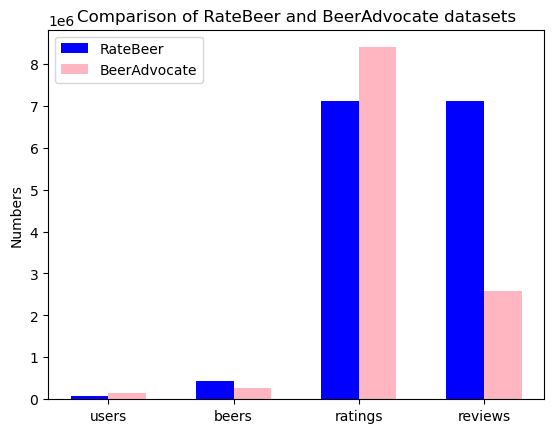

In [8]:
labels = ["users", "beers", "ratings", "reviews"]

rb_counts = [nb_users_rb, nb_beers_rb, nb_ratings_rb, nb_reviews_rb]
ba_counts = [nb_users_ba, nb_beers_ba, nb_ratings_ba, nb_reviews_ba]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
bars_rb = ax.bar(x - width/2, rb_counts, width, label='RateBeer', color='blue')
bars_ba = ax.bar(x + width/2, ba_counts, width, label='BeerAdvocate', color='lightpink')

ax.set_ylabel('Numbers')
ax.set_title('Comparison of RateBeer and BeerAdvocate datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [9]:
summary_data = {
    "Metric": ["users", "beers", "ratings", "reviews"],
    "RateBeer": [nb_users_rb, nb_beers_rb, nb_ratings_rb, nb_reviews_rb],
    "BeerAdvocate": [nb_users_ba, nb_beers_ba, nb_ratings_ba, nb_reviews_ba]
}
summary_df = pd.DataFrame(summary_data)
summary_df.style.set_caption("Summary for RateBeer and BeerAdvocate")

,Metric,RateBeer,BeerAdvocate
0,users,70174,153704
1,beers,442081,280823
2,ratings,7122074,8393032
3,reviews,7122074,2589586


The BeerAdvocate dataset provides us with enough reviews and data to perform and we will focus only on this dataset for the rest of the analysis.

1. **The Herding Effect:** As explained in the paper "When Sheep Shop: Measuring Herding Effects in Product Ratings with Natural Experiments" from Gael Lederrey and Robert West, initial ratings can influence the following ones. By focusing on a single dataset, we can better control for this effect within a single user community. Including RateBeer might introduce inconsistent herding effects that could skew comparative analyses.
2. **Inconsistant Rating Standards:** Both BeerAdvocate and RateBeer communities likely develop their own informal standards for beer ratings. Focusing on a single platform like BeerAdvocate allows dor a more cohesive dataset, with users who rate within the same context, minimizing cross-platform variance.
3. **Data Sufficiency:** The BeerAdvocate dataset provides us with enough reviews and data to perform meaningful analysis and draw reliable insights.

### Analysis of users’ countries of origin

In [10]:
# Separate the country and the states
users_ba['country'] = users_ba['location'].str.split(',').str[0]
users_ba['states'] = users_ba['location'].str.split(',').str[1]

In [11]:
missing_countries = users_ba['country'].isna().sum()
total_entries = len(users_ba)
missing_percentage = (missing_countries / total_entries) * 100

print(f"Number of missing 'country' entries: {missing_countries} ({missing_percentage:.2f}%)")

Number of missing 'country' entries: 31279 (20.35%)


In [12]:
# Replace missing 'country' values with a label "Unknown"
users_ba['country'] = users_ba['country'].fillna('Unknown')

# Compute the number of users in the top 5 countries
top5_countries = users_ba['country'].value_counts().nlargest(5)

# Compute the sum of the remaining countries (including 'Unknown' entries if any)
other_countries_count = len(users_ba) - top5_countries.sum()

# Add the "Other" countries count to the series
top_countries = pd.concat([top5_countries, pd.Series({'Other': other_countries_count})])

# Calculate percentages for each country in top_countries
top_countries_percent_ba = (top_countries / len(users_ba) * 100).round(1)

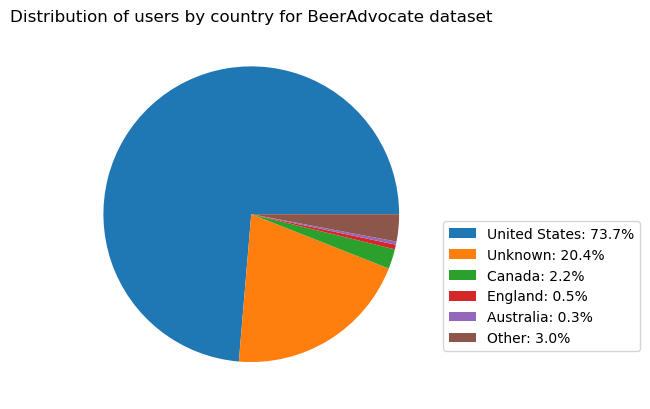

In [13]:
top_countries.plot(kind='pie', labels=None)

# Create legend with country name and percentage
top_countries_labels = [f"{country}: {percent}%" for country, percent in zip(top_countries.index, top_countries_percent_ba)]
plt.legend(labels=top_countries_labels, loc="best", bbox_to_anchor=(1, 0.5))

plt.title(f'Distribution of users by country for BeerAdvocate dataset')
plt.show()

The majority of the users are from the United States. 

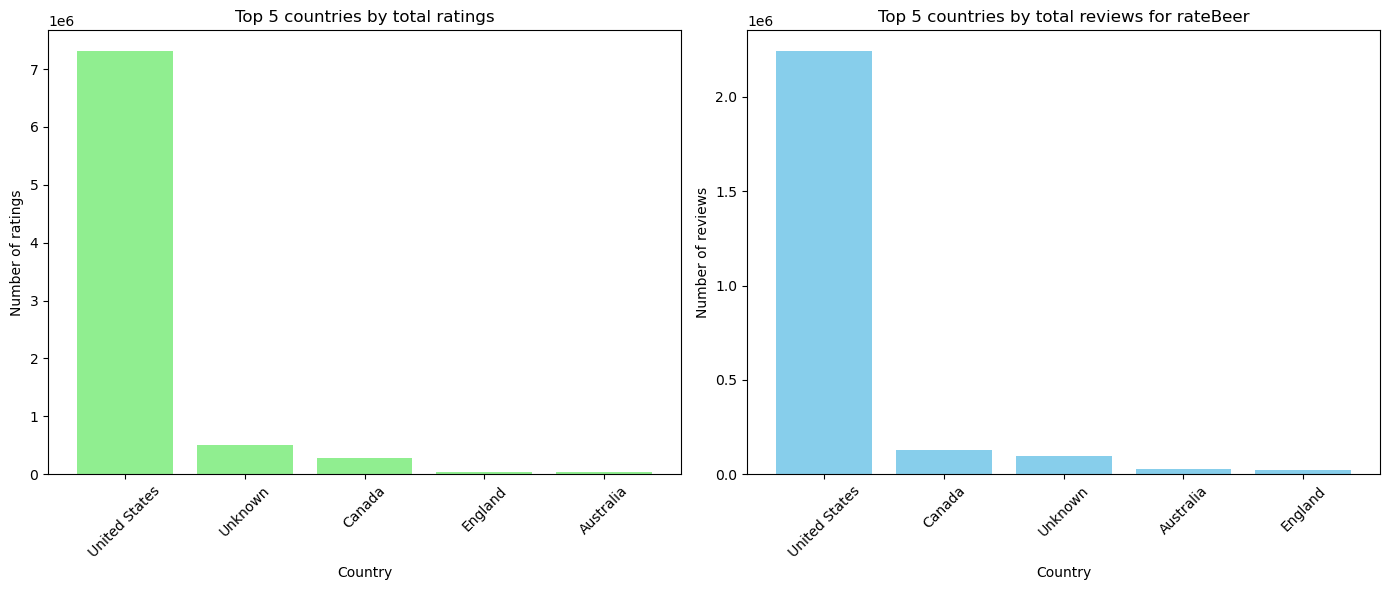

In [14]:
# Convert the number of ratings values to numeric
users_ba['nbr_ratings'] = pd.to_numeric(users_ba['nbr_ratings'], errors='coerce')
users_ba['nbr_reviews'] = pd.to_numeric(users_ba['nbr_reviews'], errors='coerce')

# Group by country and sum the ratings and the reviews
country_ratings = users_ba.groupby('country')['nbr_ratings'].sum().reset_index()
country_reviews = users_ba.groupby('country')['nbr_reviews'].sum().reset_index()

# Get the top 5 countries by number of ratings and reviews
top_countries_ratings = country_ratings.nlargest(5, 'nbr_ratings')
top_countries_reviews = country_reviews.nlargest(5, 'nbr_reviews')


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(top_countries_ratings['country'], top_countries_ratings['nbr_ratings'], color='lightgreen')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Number of ratings')
axes[0].set_title('Top 5 countries by total ratings')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(top_countries_reviews['country'], top_countries_reviews['nbr_reviews'], color='skyblue')
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Number of reviews')
axes[1].set_title('Top 5 countries by total reviews for rateBeer')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Most of the ratings and reviews are made by american users. 


Therefore, we have chosen to focus on the reviews and ratings published by users based in the United State of America. The reason for this choice is that it is the country where the majority of reviews and ratings are done, and it provides us with enough data to conduct our analysis.



In [15]:
# Keep only users from the US
users = users_ba[users_ba['country'] == 'United States']
print("There are", len(users), "users from the United States in the BeerAdvocate dataset")

# Prompt the number of ratings made by US users using the nb_ratings column of the users dataset and summing them for users where location contains United States 
print("Number of ratings made by US users: ", users[users['country'].str.contains('United States')]['nbr_ratings'].sum())

# Prompt the number of reviews made by US users using the nb_reviews column of the users dataset and summing them for users where location contains United States
print("Number of reviews made by US users: ", users[users['country'].str.contains('United States')]['nbr_reviews'].sum())

There are 113223 users from the United States in the BeerAdvocate dataset
Number of ratings made by US users:  7303870
Number of reviews made by US users:  2241334


In [16]:
# Merge the reviews with user information on location
reviews_ba = reviews_ba.merge(users_ba[['user_id', 'location']], on='user_id', how='left')

In [17]:
# Remove the states to only have the countries
reviews_ba['country'] = reviews_ba['location'].str.split(',').str[0]

# Remove the countries to only have the states
reviews_ba['states'] = reviews_ba['location'].str.split(',').str[1]

# We only keep users from the US
reviews = reviews_ba[reviews_ba['country'] == 'United States']

The reviews dataset contains now the country of origin of the users. 


The ratings datasets are not in a user-friendly format: all data is stored in a single column, with each rating’s information spread across 16 rows. As for the review dataset, it requires reshaping to extract and organize the information into distinct columns for easier analysis. Moreover, as we are only focusing on american users, it also requires filtering based on the location of the user.

In [18]:
# Reshape the ratings dataset
ratings_ba = format_data(ratings_ba, "rating_id")

In [19]:
# Merge the reviews with user information on location
ratings_ba = ratings_ba.merge(users_ba[['user_id', 'location']], on='user_id', how='left')

# Remove the states to only have the countries
ratings_ba['country'] = ratings_ba['location'].str.split(',').str[0]

# Remove the countries to only have the states
ratings_ba['states'] = ratings_ba['location'].str.split(',').str[1]

# We only keep users from the US
ratings = ratings_ba[ratings_ba['country'] == 'United States']

### Analysis of users' states of origin 

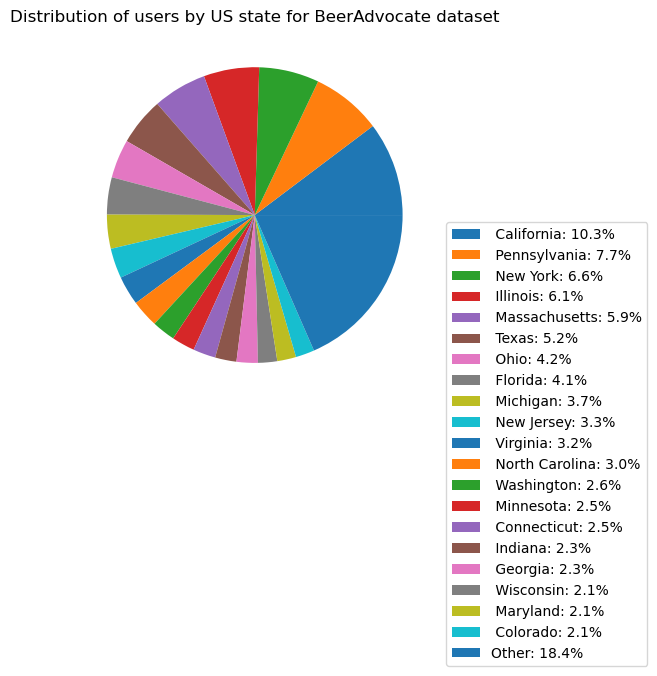

In [22]:
# Compute the number of users in the top 20 states
top20_states = users['states'].value_counts().nlargest(20)

# Compute the sum of the remaining states
other_users_count = len(users) - top20_states.sum()

# Add the "Other" states count to the series
top_states = pd.concat([top20_states, pd.Series({'Other': other_users_count})])

# Calculate percentages for each country in top_countries
top_states_percent = (top_states / len(users) * 100).round(1)

top_states.plot(kind='pie', labels=None)

# Create legend with state name and percentage
top_states_labels = [f"{state}: {percent}%" for state, percent in zip(top_states.index, top_states_percent)]
plt.legend(labels=top_states_labels, loc="best", bbox_to_anchor=(1, 0.5))

plt.title(f'Distribution of users by US state for BeerAdvocate dataset')
plt.show()

There is considerable diversity in the origins of U.S. users, with 10.3% from California, a generally warmer region, and 7.7% and 6.6% from Pennsylvania and New York, respectively, where colder climates are common.
We decided to regroup the state into 4 categories based on geographical regions in the United States:
- South: Texas, Georgia, Florida, ...
- West: California, Colorado, Washington, ...
- Northeast: New York, New Jersey, Pennsylvania, ...
- Midwest: Illinois, Michigan, Ohio, ... 

Source: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf 

In [23]:
from scripts.categorization import assign_region

users['region'] = users['states'].apply(assign_region)


In [24]:
# Count the number of users in each region
region_counts = users['region'].value_counts()
print(region_counts)

region
Northeast    32903
South        30359
Midwest      28002
West         21959
Name: count, dtype: int64


There are no users that don't have an assigned region. 

In [25]:
ratings = ratings.merge(users[['user_id', 'region']], on='user_id', how='left')
reviews = reviews.merge(users[['user_id', 'region']], on='user_id', how='left')

### Analysis of beer style

In [26]:
from scripts.categorization import get_style_map

stylemap = get_style_map()

In [27]:
#replace the style with the mapped style ()
#remove American from the style

beers_ba['style'] = beers_ba['style'].str.replace('American ', '')
beers_ba['style'] = beers_ba['style'].str.replace('German ', '')
beers_ba['style'] = beers_ba['style'].str.replace('Czech ', '')
beers_ba['style'] = beers_ba['style'].str.replace('Belgian ', '')
beers_ba['style'] = beers_ba['style'].str.replace('English ', '')
beers_ba['style'] = beers_ba['style'].str.replace('Euro ', '')
beers_ba['style'] = beers_ba['style'].str.replace('Scottish ', '')
beers_ba['style'] = beers_ba['style'].str.replace('Double / Imperial ', '')
beers_ba['style'] = beers_ba['style'].str.replace(' (APA)', '')

beers_ba['style_simp'] = beers_ba['style'].replace(stylemap)   

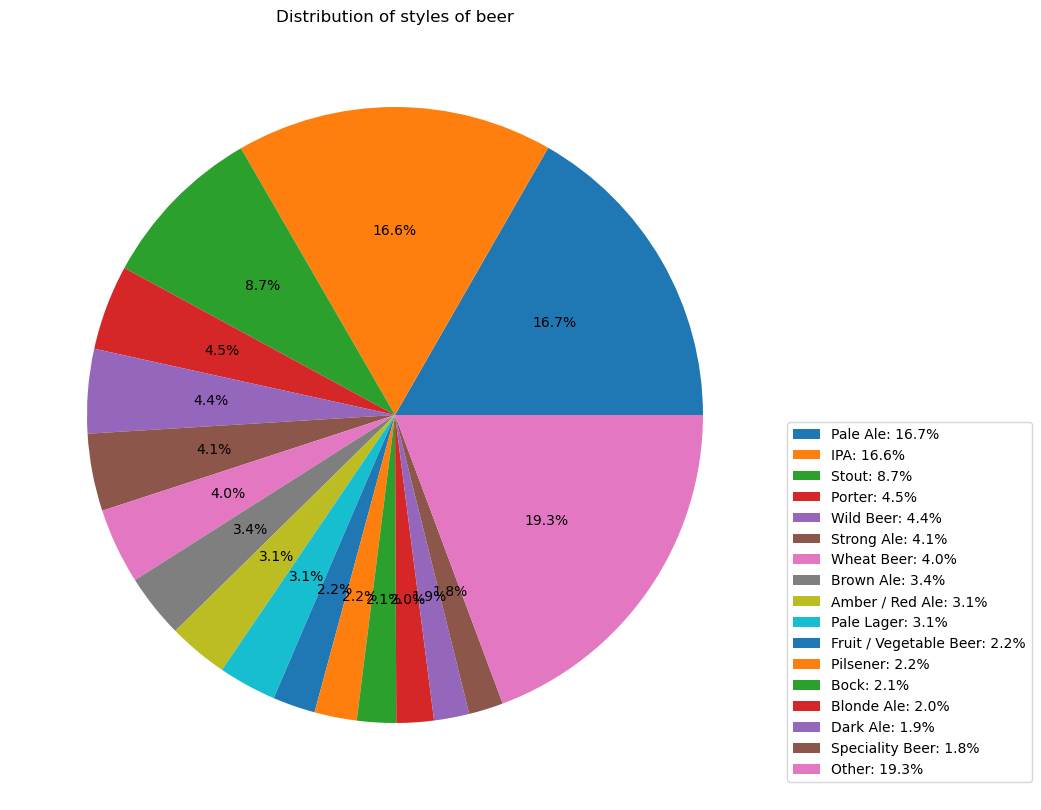

In [28]:
beers_ba['style_simp'] = beers_ba['style'].replace(stylemap)

style_count = beers_ba['style_simp'].value_counts()

# Determine the threshold for 'Other' category 
threshold = 5000  
other_count = style_count[style_count < threshold].sum()  
top_styles = style_count[style_count >= threshold]  
top_styles = pd.concat([top_styles, pd.Series({'Other': other_count})])

top_styles_percent = (top_styles / top_styles.sum() * 100).round(1)

top_styles.plot(kind='pie', labels=None, autopct='%1.1f%%', figsize=(10, 10))

top_styles_labels = [f"{style}: {percent}%" for style, percent in zip(top_styles.index, top_styles_percent)]
plt.legend(labels=top_styles_labels, loc="best", bbox_to_anchor=(1, 0.5))

plt.title('Distribution of styles of beer')
plt.show()

In [29]:
ratings_count = ratings['beer_id'].value_counts()

In [30]:
beer_counts_df = ratings_count.reset_index().rename(columns={'index': 'beer_id'})
beer_counts_df['beer_id'] = beer_counts_df['beer_id'].astype(int)
beers = beers_ba.reset_index()
beers['beer_id'] = beers['beer_id'].astype(int)

# Merge the series DataFrame with beer_ba on beer_id
result = beer_counts_df.merge(beers, on='beer_id', how='left')

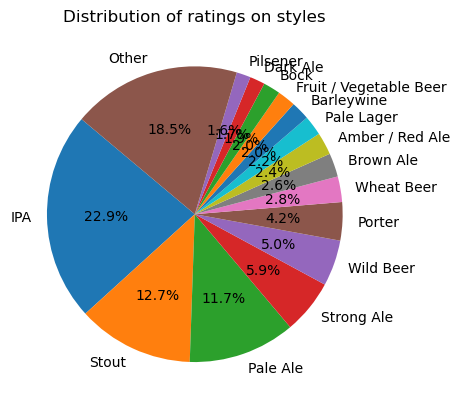

In [31]:
# Group by 'style' to get the total count for each
style_counts = result.groupby('style_simp')['count'].sum().sort_values(ascending=False)

# Define a threshold for the 'Other' category
threshold = 100000 
other_count = style_counts[style_counts < threshold].sum()
top_styles = style_counts[style_counts >= threshold]

top_styles = pd.concat([top_styles, pd.Series({'Other': other_count})])

plt.pie(top_styles, labels=top_styles.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of ratings on styles')

plt.show()

In [32]:
total_count = style_count.sum()
threshold = 0.02 * total_count

# Filter styles with a count greater than or equal to 2% of the total count
beer_styles_above_2_percent = style_count[style_count >= threshold].index.tolist()

In [33]:
reviews = reviews.merge(beers[['beer_id','style_simp']], on='beer_id', how='left')
ratings = ratings.merge(beers[['beer_id','style_simp']], on='beer_id', how='left')

### Analysis of the beer percentage of alcohol by volume

In [34]:
reviews['abv'].describe()

count    2.181501e+06
mean     7.254056e+00
std      2.385050e+00
min      1.000000e-02
25%      5.400000e+00
50%      6.800000e+00
75%      8.700000e+00
max      6.750000e+01
Name: abv, dtype: float64

We can categorize beer types based on their Alcohol by Volume (ABV) percentage as follows:
- **low ABV**: 0-25% quantile → ABV up to 5.5%
- **medium ABV**: 25%-75% quantile → ABV between 5.5% and 8.8%
- **high ABV**: 75%-100% quantile → ABV higher than 8.8%

In [35]:
# Calculate the quantiles
abv_quantiles = reviews['abv'].quantile([0.25, 0.5, 0.75])

from scripts.categorization import categorize_abv

reviews['abv_category'] = reviews['abv'].apply(lambda x: categorize_abv(x, abv_quantiles))
ratings['abv_category'] = ratings['abv'].apply(lambda x: categorize_abv(x, abv_quantiles))

### Analysis of the publication timing of user reviews

In [36]:
# Extract the year, month, and day
reviews['date']  = pd.to_datetime(reviews['date'], unit='s', errors='coerce')
reviews['year'] = reviews['date'].dt.year
reviews['month'] = reviews['date'].dt.month
reviews['day'] = reviews['date'].dt.day

In [37]:
# Extract the year, month, and day
ratings['date']  = pd.to_datetime(ratings['date'], unit='s', errors='coerce')
ratings['year'] = ratings['date'].dt.year
ratings['month'] = ratings['date'].dt.month
ratings['day'] = ratings['date'].dt.day

In [38]:
from scripts.categorization import get_season

In [39]:
# Separate the reviews by seasons
reviews['season'] = reviews['month'].apply(get_season)

# Separate the ratings by seasons
ratings['season'] = ratings['month'].apply(get_season)

**Over the years**

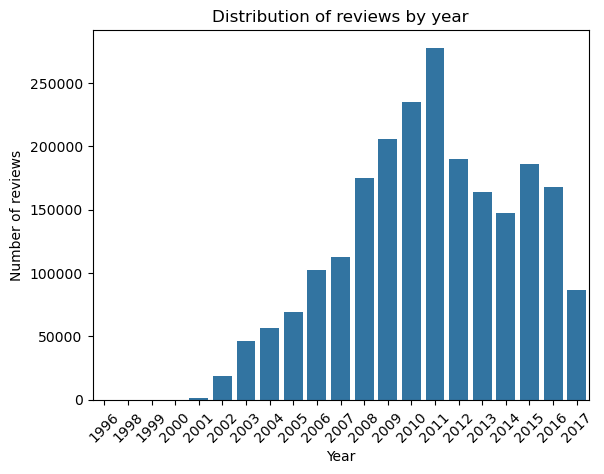

In [40]:
# Plot yearly review counts

sns.countplot(data=reviews, x='year', legend=False)
plt.title('Distribution of reviews by year')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.xticks(rotation=45)
plt.show()

We can see that before 2002, there are few reviews given by users on the BeerAdvocate website. We can choose a threshold of a minimum of 70'000 reviews by year to have enough reviews published by year to analyze the change over a year.

In [41]:
# Count the number of reviews by year
reviews_per_year = reviews['year'].value_counts()

# Filter to keep only years with more than 70'000 reviews
years_above_threshold = reviews_per_year[reviews_per_year > 70000].index
reviews = reviews[reviews['year'].isin(years_above_threshold)]
ratings = ratings[ratings['year'].isin(years_above_threshold)]

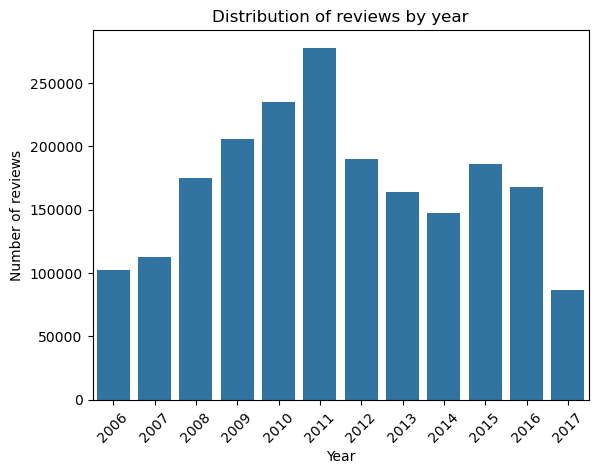

In [42]:
sns.countplot(data=reviews, x='year')
plt.title('Distribution of reviews by year')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.xticks(rotation=45)
plt.show()

We now have only reviews published between 2006 and 2017

**Across the seasons**

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


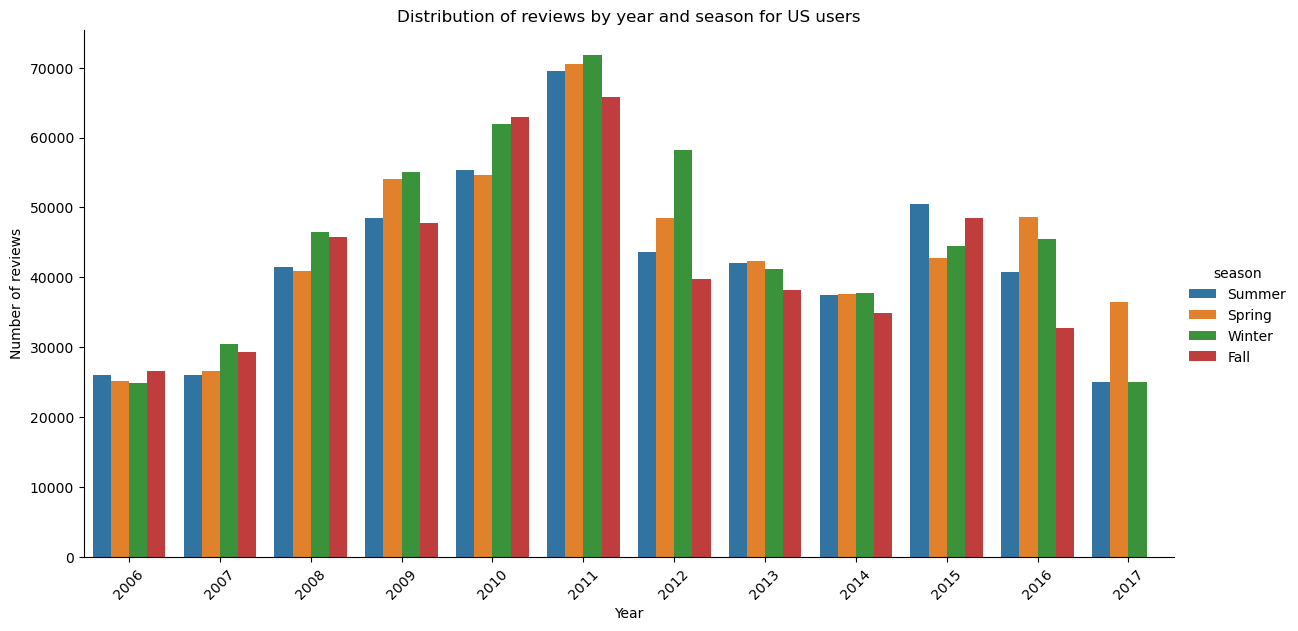

In [43]:
sns.catplot(data=reviews, x='year', hue='season', kind='count', height=6, aspect=2, legend=True)
plt.title('Distribution of reviews by year and season for US users')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.xticks(rotation=45)
plt.show()

Between 2006 and 2017, there is no distinct season with consistently higher review activity, except for notable peaks in Winter 2012 and Spring 2017.

## Seasonal trend analysis

To understand the seasonal analysis, it is important to understand how the beers are rated. In both reviews and ratings dataframes, 6 columns contain metrics ( which are a score out of 5): appearance, aroma, taste, mouthfeel, overall and rating. The rating metrics is computed based on the 5 other scores with the following formula:
$$
\text{rating} = 0.06 \cdot \text{appearance} + 0.24 \cdot \text{aroma} + 0.4 \cdot \text{taste} + 0.1 \cdot \text{mouthfeel} + 0.2 \cdot \text{overall}
$$


In [45]:
from src.scripts.script import anova_test

In [ ]:
print("Number of NaN values in ratings:", ratings['rating'].isnull().sum())

Number of NaN values in ratings:  444092


In [47]:
ratings = ratings.dropna(subset=['rating'])

In [48]:
rating_columns = ['aroma', 'palate', 'appearance', 'taste', 'overall', 'rating']

season_order = ['Winter', 'Spring', 'Summer', 'Fall']
ratings['season'] = pd.Categorical(ratings['season'], categories=season_order, ordered=True)